In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import os
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree

In [13]:
def load_pressure_predictor(load_directory):
    model = SplineCNN8Residuals(3)
    model.load_state_dict(torch.load(load_directory + "/cfdModel.nn"))
    model = model.to("cuda:0").eval()
    return model

def load_latent_vectors(load_directory, checkpoint):
    filename = os.path.join(
        load_directory, checkpoint + ".pth"
    )
    if not os.path.isfile(filename):
        raise Exception(
            "The experiment directory ({}) does not include a latent code file"
            + " for checkpoint '{}'".format(load_directory, checkpoint)
        )
    data = torch.load(filename)
    return data["latent_codes"].cuda()

def load_decoder(load_directory, checkpoint):
    specs_filename = os.path.join(load_directory, "specs.json")
    if not os.path.isfile(specs_filename):
        raise Exception(
            'The experiment directory does not include specifications file "specs.json"'
        )
    specs = json.load(open(specs_filename))
    latent_size = specs["CodeLength"]
    decoder = Decoder(latent_size, **specs["NetworkSpecs"])
    decoder = torch.nn.DataParallel(decoder)
    saved_model_state = torch.load(os.path.join(load_directory, checkpoint +".pth"))
    decoder.load_state_dict(saved_model_state["model_state_dict"])
    decoder = decoder.module.cuda()
    decoder.eval()
    return decoder

In [14]:
DIR_to_load_data = 'starting_data'
experiment_directory = "data_for_this_experiments"

#predictor = load_pressure_predictor(DIR_to_load_data)

#decoder = load_decoder(DIR_to_load_data, "decoderModel")

latent_vectors = load_latent_vectors(DIR_to_load_data, "latentCodes").detach()

AvgTransform = np.load(DIR_to_load_data + "/avg_trans_matrix.npy") #computeAvgTransform()

LATENT_TO_OPTIMIZE = latent_vectors[32]
LATENT_KD_TREE = KDTree(np.array([lv.cpu().detach().numpy()[0] for lv in latent_vectors]))
# /cvlabdata2/home/artem/Data/cars_remeshed_dsdf/transforms/"

In [17]:
data = latent_vectors.squeeze().cpu()

In [27]:
pca_2 = PCA(n_components=2)
pca_2.fit(data)
pca_result_2 = pca_2.transform(data)

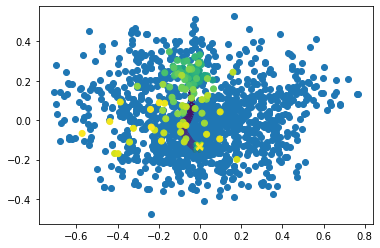

In [69]:
plt.scatter(pca_result_2[:,0], pca_result_2[:,1])
plt.scatter(pca_result_2[32,0], pca_result_2[32,1], marker='o', label='tab:red')
plt.scatter(pca_sgd_res[:,0], pca_sgd_res[:,1], marker='x', c=np.arange(200))
plt.scatter(pca_cma_res[:,0], pca_cma_res[:,1], marker='o', c=np.arange(pca_cma_res.shape[0]))

In [43]:
sgd_latent = np.load("../Compare_optimisers/SGD/latent_series.npy", allow_pickle=True)
lats = [a for a in sgd_latent]
lats = torch.stack(lats).squeeze().detach().cpu()
pca_sgd_res = pca_2.transform(lats.detach().cpu())
plt.scatter(pca_sgd_res[:,0], pca_sgd_res[:,1], c=np.arange(200))

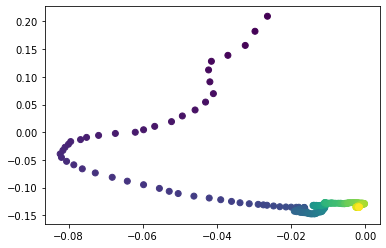

In [53]:
plt.scatter(pca_sgd_res[:,0], pca_sgd_res[:,1], c=np.arange(200))

In [67]:
cma_sgd = np.load("../Compare_optimisers/CMASGD/latent_series.npy")
cmasgd_latent = cma_sgd.squeeze()
pca_cmasgd_res = pca_2.transform(cmasgd_latent)

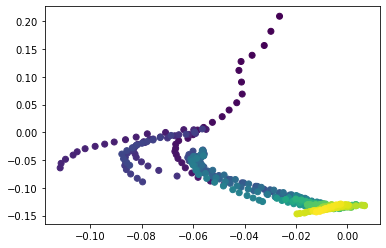

In [68]:
plt.scatter(pca_cmasgd_res[:,0], pca_cmasgd_res[:,1], c=np.arange(pca_cmasgd_res.shape[0]))

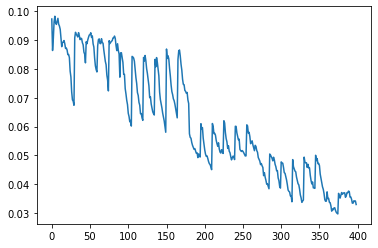

In [70]:
cma_sgd_phy = np.load("../Compare_optimisers/CMASGD/phy_loss.npy")
plt.plot(cma_sgd_phy)

In [56]:
cma_latent = np.load("../Compare_optimisers/CMA/latent_series.npy", allow_pickle=True)
cma_latent = cma_latent.squeeze()
pca_cma_res = pca_2.transform(cma_latent)

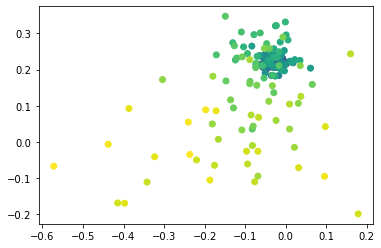

In [63]:
plt.scatter(pca_cma_res[:,0], pca_cma_res[:,1], c=np.arange(pca_cma_res.shape[0]))